In [1]:
%%capture
#!pip install ffmpeg
!pip3 install ffmpeg-python
!pip install sk-video
#!pip install ffmpeg-python

In [2]:
import json
import cv2
import os
import pandas as pd
import numpy as np
from itertools import compress
import matplotlib.pyplot as plt
import pylab
import imageio
import ffmpeg
from sklearn.model_selection import train_test_split
from skimage.io import imsave
import numpy as np
import skvideo.io
from IPython.core.application import ensure_dir_exists

In [3]:
# mount drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#---------------------------------------------------------------------------------------------------------------
# Initial checks 
#---------------------------------------------------------------------------------------------------------------

In [4]:
# gets all files/directory in Video_Results
all_docs = []
# path to folder with all our documents
path_to_CV = "drive/Shareddrives/CV_videos/"
# path to folder with results from open-alpha
path_to_videoResults = path_to_CV + "Video_Results/"

# check if working directory is set correctly and find all directories in folder for VideoResults
if os.getcwd() == "/content":
    print("Getting all files from 'Video_Results/' folder...")
    all_docs = [files for files in os.listdir(path_to_videoResults)]
else:
    raise NameError("Set path to '/content' before running this cell")

# This cleans up all_docs and removes those docs that are not directories
print("Deleting all non-directory files in 'Video_Results/' folder...")
for f in all_docs:
    path_folder = path_to_videoResults + str(f)
    if os.path.isfile(path_folder):
        all_docs.remove(f)

# append path to all .json files to list, raise ERROR is one of the files is not .json
all_json_files = []
print("Compiling list of all .json files available")
for dir in all_docs:
    path_into_dir = path_to_videoResults + str(dir) + "/"
    for json_file in os.listdir(path_into_dir):
        if json_file.endswith(".json"):
            all_json_files.append(path_into_dir + json_file)
        else:
            raise NameError("ERROR: Some files in" + path_into_dir + "are not .json files.")

# get general info on files 
general_info = pd.read_csv(path_to_CV + "other_docs/SVW.csv", sep = ";")[["FileName", "Genre", "W", "H", "# frames", "FPS", "Length (s)"]]

Getting all files from 'Video_Results/' folder...
Deleting all non-directory files in 'Video_Results/' folder...
Compiling list of all .json files available


# Functions

These are two functions which are used below in the code. The first one just gets the shape of a video at a specified location, the second one selects the winner in case there is more than one person that appears in all frames. The winner in the person which appears in the center the most. 

In [9]:
# Not all video have the same shape!
# Helper function -- we read in a file name and it tells us whether the image is vertical or horizontal
def get_shape_video(video_filename: str, verbose = False):
    vid = imageio.get_reader(video_filename,  'ffmpeg')
    image = vid.get_data(0) # gets colors of first frame 
    shape_image = image.shape
    if verbose == True:
        print("Shape of image: ", shape_image)
    return shape_image[0:2]

# Checks which person is more central if there are several winners
def diff_between_several_winner(sum_along_col: list[int], all_Fpp, max_nr_ppl_frame, video_filename: str):
    
    total_nr_frames = int(list(all_Fpp.keys())[-1].strip("person").lstrip(str(max_nr_ppl_frame - 1)).lstrip("_f"))
    list_av_width = []
    list_av_height = []
    nr_frames_appearing = 0
        

    for person in range(max_nr_ppl_frame):
        nr_frames_appearing = 0
        total_w = 0
        total_h = 0

        for frame in range(total_nr_frames):
            if all_Fpp["person"+str(person)+"_f"+str(frame)][0] > 0:
                nr_frames_appearing += 1

                total_w += all_Fpp["person"+str(person)+"_f"+str(frame)][0]
                total_h += all_Fpp["person"+str(person)+"_f"+str(frame)][1]

        if nr_frames_appearing > 0:
            total_w /= nr_frames_appearing
            total_h /= nr_frames_appearing

        list_av_width.append(total_w)
        list_av_height.append(total_h)


    
    max_area = []

    for i in range(len(list_av_width)):
        area = list_av_width[i] * list_av_height[i]
        max_area.append(area)
    
    return np.argmax(max_area)

In [10]:
path_to_sports = "/content/drive/Shareddrives/CV_videos/Video_Processed/"
cleaned_json = "/content/drive/Shareddrives/CV_videos/Cleaned_json/"
path_to_video_results = "/content/drive/Shareddrives/CV_videos/Video_Results/"

path_to_sports = "/content/drive/Shareddrives/CV_videos/Video_Processed/"
path_to_cleaned_json = "/content/drive/Shareddrives/CV_videos/Cleaned_json/"
path_to_posture_videos = "/content/drive/Shareddrives/CV_videos/Posture_videos"

#---------------------------------------------------------------------------------------------------------------
# JSON to cleaned JSON 
#---------------------------------------------------------------------------------------------------------------

# Create cleaned JSON
Idally this will have selected the key/central actor and only use the json from him.

In [ ]:
#!rm -rf /content/drive/Shareddrives/CV_videos/Cleaned_json/*

In [ ]:
for folder_sport in os.listdir(path_to_sports):
    if not os.path.isdir(os.path.join(cleaned_json, folder_sport)):
        os.mkdir(os.path.join(cleaned_json, folder_sport))

    clean_dir_sport = os.path.join(cleaned_json, folder_sport)

    print("Doing " + str(folder_sport))
    for video in os.listdir(os.path.join(path_to_sports, folder_sport)):
        print("Doing the following video: ", video)
        skip = False
        videoName = video.strip(".mp4")
        sport = folder_sport

        exists = os.path.isfile(path_to_video_results + str(folder_sport) + "/" + videoName + str(".json"))
        already_converted = os.path.isfile(os.path.join(clean_dir_sport, videoName + str(".json")))
        
        if (not already_converted) and exists:
            video = videoName + str(".json")
            video_filename = path_to_sports+str(folder_sport)+"/"+str(videoName)+'.mp4'

            f = open(path_to_video_results + str(folder_sport) + "/" + video)
            data = json.load(f)

            # list where each entries denotes which frame a given key point belongs to
            key_per_img = [int((dic['image_id']).strip(".jpg")) for dic in data]

            # total number of frames in image
            nr_of_frames = key_per_img[-1] + 1

            # gets top right x and y of each bounding box in each frame of each person appearing
            bounding_box_per_img = [dic["box"][0: 4] for dic in data] #gets x,y,w,h

            # calculates the maximum number of people appearing in each video
            max_nr_ppl_frame = 0
            for i in range(nr_of_frames):
                nr_ppl_frame = len(np.where(np.array(key_per_img) == i)[0])
                if nr_ppl_frame > max_nr_ppl_frame:
                    max_nr_ppl_frame = nr_ppl_frame

            # creates array that will help us distinguish which person appears when and what the respective
            # key point coordinates are 
            person_id_keypoint_order = np.full((nr_of_frames, max_nr_ppl_frame), fill_value = 0)

            # create dic to store all values of bounding box
            keys = []
            for frame in range(nr_of_frames):
                for nr in range(max_nr_ppl_frame):
                    keys.append("person" + str(nr) + "_f" + str(frame))

            values = [[0, 0] for frame in range(nr_of_frames) for j in range(max_nr_ppl_frame)]

            all_Fpp = dict(zip(keys, values))

            # creates array that contains information of whether a given person appears
            # in a given frame of the video. This will be used to later the filter key
            # points and only retain those of the central person of interest.

            #first_frame_in_which_person_detected = int((data[0]["image_id"]).strip(".jpg"))
            
            first_frame = 60 # this gets rid of some corner cases at the beginning when the camera is not stable etc. 
            for frame in range(first_frame, nr_of_frames):
                box_idx = list(np.where(np.array(key_per_img) == frame)[0])
                bounding_box_subset = [bounding_box_per_img[i] for i in box_idx]

                if frame == first_frame:
                    for ppl in range(len(box_idx)):
                        (all_Fpp["person" + str(ppl) + "_f" + str(frame)])[0] = (bounding_box_subset[ppl][2]) # width
                        (all_Fpp["person" + str(ppl) + "_f" + str(frame)])[1] = (bounding_box_subset[ppl][3]) # height
                        person_id_keypoint_order[frame, ppl] = 1
                else: 
                    for ppl in range(len(box_idx)):
                        point_to_match_x = (bounding_box_subset[ppl][2])
                        point_to_match_y = (bounding_box_subset[ppl][3])

                        min_dis = np.inf 
                        idx = -1
                        if not skip:
                            try:
                                for ppl_prior_frame in range(max_nr_ppl_frame):
                                    for depth in range(15): # compares to half a second before in cases there is short occlusion
                                        if depth >= frame: # not much change expected in this half a second
                                            pass
                                        else:
                                            p_old_x = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][0]
                                            p_old_y = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][1]

                                            if p_old_x < 0 or p_old_y < 0:
                                                pass
                                            else:
                                                distance = np.sqrt((point_to_match_x - p_old_x)**2 + (point_to_match_y - p_old_y)**2)
                                                if distance < min_dis:
                                                    min_dis = distance
                                                    idx = ppl_prior_frame

                                #print(all_Fpp["person" + str(idx) + "_f" + str(frame)])
                                (all_Fpp["person" + str(idx) + "_f" + str(frame)])[0] = point_to_match_x
                                (all_Fpp["person" + str(idx) + "_f" + str(frame)])[1] = point_to_match_y
                                person_id_keypoint_order[frame, idx] = 1
                            except KeyError:
                                try: 
                                    for ppl_prior_frame in range(max_nr_ppl_frame):
                                        for depth in range(200):
                                            if depth >= frame:
                                                pass
                                            else:
                                                p_old_x = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][0]
                                                p_old_y = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][1]

                                                if p_old_x < 0 or p_old_y < 0:
                                                    pass
                                                else:
                                                    distance = np.sqrt((point_to_match_x - p_old_x)**2 + (point_to_match_y - p_old_y)**2)
                                                    if distance < min_dis:
                                                        min_dis = distance
                                                        idx = ppl_prior_frame
                                    #print(all_Fpp["person" + str(idx) + "_f" + str(frame)])
                                    (all_Fpp["person" + str(idx) + "_f" + str(frame)])[0] = point_to_match_x
                                    (all_Fpp["person" + str(idx) + "_f" + str(frame)])[1] = point_to_match_y
                                    person_id_keypoint_order[frame, idx] = 1
                                except KeyError:
                                    print("Issue with this one")
                                    skip = True
                                    break



            # selects winner - person that is most often captured -> central element of 
            # video -> person of interest
            if not skip:
                sum_along_col = np.sum(person_id_keypoint_order, axis = 0)

                if len(np.argwhere(sum_along_col == np.amax(sum_along_col))) > 1:
                    person_winner = diff_between_several_winner(sum_along_col, all_Fpp, max_nr_ppl_frame, video_filename)
                    #print("Person of interest: ", person_winner)
                else:
                    person_winner = np.argmax(sum_along_col)
                    #print("Person of interest: ", person_winner)


                # deletes values of all non-winning person from list with box coordinates
                # this list contains now x,y value from the bounding box only for the person
                # that has been named the winner -> central element of video
                for i in range(len(all_Fpp)):
                    for nr in range(max_nr_ppl_frame):
                        if nr == person_winner:
                            pass
                        else:
                            if "person" + str(nr) + "_f" + str(i) in all_Fpp:
                                del all_Fpp["person" + str(nr) + "_f" + str(i)]

                # creates boolean array that checks if a given dic of keypoint (17 values + box + etc.) is from
                # winning person or not
                boolean_sel = []

                for frame in range(nr_of_frames):
                    idx_ppl_in_frame = list(np.where(np.array(key_per_img) == frame)[0])
                    collection_of_keyspoints_subset = [data[i] for i in idx_ppl_in_frame]
                    bounding_box_winner_x = all_Fpp["person" + str(person_winner) + "_f" + str(frame)][0]
                    bounding_box_winner_y = all_Fpp["person" + str(person_winner) + "_f" + str(frame)][1]

                    for pot_key_point in range(len(collection_of_keyspoints_subset)):
                        potential_x = collection_of_keyspoints_subset[pot_key_point]["box"][2]
                        potential_y = collection_of_keyspoints_subset[pot_key_point]["box"][3]

                        if bounding_box_winner_x == potential_x and bounding_box_winner_y == potential_y:
                            boolean_sel.append(True)
                        else:
                            boolean_sel.append(False)


                # subset the full list of keyspoints and select only the ones that match the winning person
                finaldata = list(compress(data, boolean_sel))

                # Writing to location of interest
                path_of_interest = os.path.join(path_to_cleaned_json, folder_sport, videoName + str(".json"))
                with open(path_of_interest, "w") as outfile:   
                    json.dump(finaldata, outfile)


Doing baseball
Doing the following video:  1006___0782c5e0a492407a8c250f933b5b86b6.mp4
Doing the following video:  1031___768ac4dd639549d38838a1103bb81d51.mp4
Doing the following video:  1092___ffbc359e04534e568514b7ec58e568a7.mp4
Doing the following video:  1099___698b4b4bd16849f68e055c9b501847ff.mp4
Doing the following video:  1111___7dc29273c6e4421883538b33b4f056bb.mp4
Doing the following video:  1261___8332104211f94b6784dafa0ffad383df.mp4
Doing the following video:  1265___266aac5e514340688711a5b8d4caf303.mp4
Doing the following video:  1302___1712b53abeb5475d90a56273c4ce228d.mp4
Doing the following video:  1307___884b1eed93294c788bdf0df94ef270c9.mp4
Doing the following video:  1319___7f848fe657c64dddb503ab0492d494f9.mp4
Doing the following video:  1338___161908111f804655b891fab83dfb6b83.mp4
Doing the following video:  1361___11eaf770ed334cb9aa9b8f28515a8882.mp4
Doing the following video:  136___a5ae4b2b86274243b593a3194e2ff6f9.mp4
Doing the following video:  1399___ed35d4d4bfcb42d

#---------------------------------------------------------------------------------------------------------------
# JSON to VIDEO 
#---------------------------------------------------------------------------------------------------------------

# Convert all JSON into videos of posture for the selected figure

This takes a JSON file and makes a video with the posture keypoints of a single person. 



In [ ]:
!rm folder_images_video_creation/*

In [ ]:
!mkdir folder_images_video_creation

connections = [(0, 1), (0, 2), (2, 4), (1, 3), (0, 5), (0, 6), (5, 7), (6, 8), (7, 9), (8, 10), (0, 11), (0, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

check = []
for i in range(17):
    check = check + [True, True, False]

for folder_sport in os.listdir(path_to_cleaned_json):
    print("Doing " + str(folder_sport) + "...")
    for json_of_video in os.listdir(os.path.join(path_to_cleaned_json, folder_sport)):
        print("Doing " + str(json_of_video))
        if not os.path.isfile(os.path.join(path_to_posture_videos, folder_sport, json_of_video.strip(".json") + str(".mp4"))):
            full_file_path = os.path.join(path_to_cleaned_json, folder_sport, json_of_video)
            f = open(full_file_path)
            cleaned_data_json = json.load(f)

            total_nr_frames = len(cleaned_data_json)
            H, W = get_shape_video(os.path.join(path_to_sports, folder_sport, json_of_video.strip(".json") + str(".mp4")), verbose = False)


            for i in range(0, total_nr_frames, 15):
                frame_nr = i
                frame = cleaned_data_json[frame_nr:frame_nr+1]
                frame_keypoints = [dic["keypoints"] for dic in frame]
                frame_boundingbox = [dic["box"] for dic in frame]

                frame_keypoints = np.array(frame_keypoints)[:, check]
                
                frame_keypoints = frame_keypoints.reshape(-1, 2)

                # POSTURE POSITION
                fig, ax = plt.subplots()

                # Create a black image with the correct size
                
                image = np.zeros((H, W, 3), dtype=np.uint8)

                # Set all pixels to black
                image[:, :, :] = [0, 0, 0]
                plt.imshow(image) # black background

                # Draw Posture
                try:
                    for connection in connections:
                        start_idx, end_idx = connection
                        start_point = frame_keypoints[start_idx]
                        end_point = frame_keypoints[end_idx]
                        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='red', linewidth=2)
                except IndexError:
                    pass

                plt.ioff()
                plt.tight_layout()

                plt.savefig("/content/folder_images_video_creation/image_" +str(i), transparent=True)


            H, W = get_shape_video(os.path.join(path_to_sports, folder_sport, json_of_video.strip(".json") + str(".mp4")), verbose = False)
            out_video =  np.empty([total_nr_frames, H, W, 3], dtype = np.uint8)
            out_video =  out_video.astype(np.uint8)

            for i in range(0, total_nr_frames, 15):
                img = cv2.imread("/content/folder_images_video_creation/image_" + str(i)+'.png')
                img = cv2.resize(img, (W, H), interpolation = cv2.INTER_CUBIC)
                out_video[i] = img

            #Writes the the output image sequences in a video file
            target_dir_video = os.path.join(path_to_posture_videos, folder_sport, json_of_video.strip(".json") + str(".mp4"))
            try:
                skvideo.io.vwrite(target_dir_video, out_video, outputdict={"-pix_fmt": "yuv420p", '-b': '30000000'})
            except AttributeError:
                print("Error occured, move on")
                pass

            !rm folder_images_video_creation/*


!rm -rf folder_images_video_creation

Doing baseball...
Doing 1006___0782c5e0a492407a8c250f933b5b86b6.json
Doing 1031___768ac4dd639549d38838a1103bb81d51.json
Doing 1092___ffbc359e04534e568514b7ec58e568a7.json
Doing 1099___698b4b4bd16849f68e055c9b501847ff.json
Doing 1111___7dc29273c6e4421883538b33b4f056bb.json
Doing 1261___8332104211f94b6784dafa0ffad383df.json
Doing 1265___266aac5e514340688711a5b8d4caf303.json
Doing 1302___1712b53abeb5475d90a56273c4ce228d.json
Doing 1307___884b1eed93294c788bdf0df94ef270c9.json
Doing 1319___7f848fe657c64dddb503ab0492d494f9.json
Doing 1338___161908111f804655b891fab83dfb6b83.json
Doing 1361___11eaf770ed334cb9aa9b8f28515a8882.json
Doing 136___a5ae4b2b86274243b593a3194e2ff6f9.json
Doing 1399___ed35d4d4bfcb42dca6094b825ab15bff.json
Doing 1428___088d10d336b145ef98da55b4b7e5fbf2.json
Doing 1436___1f90955b1b944623a06819a29c93bd83.json
Doing 1448___52effe67150f45cc9c7c26671001e0f6.json
Doing 1449___a3531d97e6df42ae9072fc069567737e.json
Doing 1464___dbe56e9398864ee693afd844cd5ae8b5.json
Doing 1466___2

#---------------------------------------------------------------------------------------------------------------
# Plot Posture for frame 
#---------------------------------------------------------------------------------------------------------------

# Plot posture, bounding box, real image and image plus posture for given video at specified frame. 

Note that if uncleaned data (and if more than one actor appears in the video) is read in, frame_nr_in_video does not specify the frame but the stored keypoint. E.g. if 2 people appear in 100 frames, frame_nr_in_video = 50 means that the 25 frame of the secon person will appear. 



In [11]:
# Feed in frame  ONE PERSON IS IN IMAGE
def show_posture_frame_main_person(data, video_filename, frame_nr_in_video = 0):
    # How KeyPoints are connected 
    # {0,  "Nose"},
    # {1,  "LEye"},
    # {2,  "REye"},
    # {3,  "LEar"},
    # {4,  "REar"},
    # {5,  "LShoulder"},
    # {6,  "RShoulder"},
    # {7,  "LElbow"},
    # {8,  "RElbow"},
    # {9,  "LWrist"},
    # {10, "RWrist"},
    # {11, "LHip"},
    # {12, "RHip"},
    # {13, "LKnee"},
    # {14, "Rknee"},
    # {15, "LAnkle"},
    # {16, "RAnkle"}

    connections = [(0, 1), (0, 2), (2, 4), (1, 3), (0, 5), (0, 6), (5, 7), (6, 8), (7, 9), (8, 10), (0, 11), (0, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

    frame_nr = frame_nr_in_video
    frame = data[frame_nr:frame_nr+1]

    frame_for_video = int(frame[0]["image_id"].strip(".jpg"))

    print("Note: This image is frame " + str(frame_for_video) + " of the video.")
    frame_keypoints = [dic["keypoints"] for dic in frame]
    frame_boundingbox = [dic["box"] for dic in frame]
    check = np.array(frame_keypoints) > 1
    frame_keypoints = np.array(frame_keypoints)[check]
    frame_keypoints = frame_keypoints.reshape(-1, 2)

    # DRAW BOX AND PERSON
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

    # POSTURE POSITION

    # Create a black image with the correct size
    H, W = get_shape_video(video_filename, verbose = False)
    image = np.zeros((H, W, 3), dtype=np.uint8)

    # Set all pixels to black
    image[:, :, :] = [0, 0, 0]
    x_box_min, y_box_bmin, box_width, box_height = frame_boundingbox[0]

    ax1.imshow(image) # black background
    for connection in connections:
        start_idx, end_idx = connection
        start_point = frame_keypoints[start_idx]
        end_point = frame_keypoints[end_idx]
        ax1.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='red', linewidth=2)

    ax1.add_patch(plt.Rectangle((x_box_min, y_box_bmin), box_width, box_height, fill=False, edgecolor='green', linewidth=2))
    ax1.axis('off')

    # REAL IMAGE
    vid = imageio.get_reader(video_filename,  'ffmpeg')
    image = vid.get_data(frame_for_video)
    ax2.imshow(image)
    ax2.axis('off')

    # BOTH OVERLAYED
    ax3.imshow(image)
    ax3.axis("off")
    for connection in connections:
        start_idx, end_idx = connection
        start_point = frame_keypoints[start_idx]
        end_point = frame_keypoints[end_idx]
        ax3.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='red', linewidth=2)

    plt.tight_layout()
    plt.show()

Note: This image is frame 140 of the video.


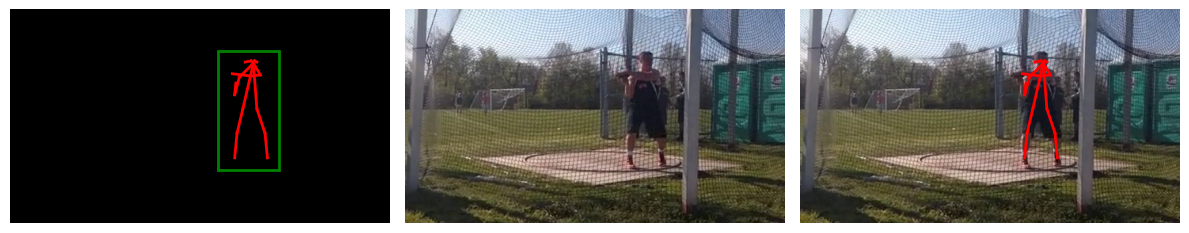

In [41]:
# Specify which video
from_cleaned_json = True
path = "/content/drive/Shareddrives/CV_videos/"
sport = "discusthrow"
idx = 14
where_in_video = 80

# select path according to selection
name_of_video = os.listdir(os.path.join(path, "Video_Processed", sport))[idx]
if from_cleaned_json:
    path_json = os.path.join(path, "Cleaned_json", sport, name_of_video.strip(".mp4") + str(".json"))
else:
    path_json = os.path.join(path, "Video_Results", sport, name_of_video.strip(".mp4") + str(".json"))
video_filename = os.path.join(path, "Video_Processed", sport, name_of_video)


try:
    f = open(path_json)
    data_for_plotting = json.load(f)
    show_posture_frame_main_person(data_for_plotting, video_filename, where_in_video)
except FileNotFoundError:
    print("Unfortunately the clean JSON file for this video does not exist. Either it hasn't been generated yet or it is out of bounds.")



#---------------------------------------------------------------------------------------------------------------
# Train, Val, Test Set 
#---------------------------------------------------------------------------------------------------------------

# Create Train Validation & Test Sets based on all videos

In [ ]:
# get general info on files 
general_info = pd.read_csv(path_to_CV + "other_docs/SVW.csv", sep = ";")[["FileName", "Genre", "W", "H", "# frames", "FPS", "Length (s)"]]
categories_of_interest = ["archery", "baseball", "basketball", "bowling", "discusthrow", "golf", "gymnastics", "hammerthrow", "highjump", "javelin", "longjump", "polevault", "running", "shotput", "weight"]
data_of_interest = general_info[general_info["Genre"].isin(categories_of_interest)]

In [ ]:
X = data_of_interest[["FileName"]]
y = data_of_interest["Genre"][:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify=y_train)

X_train["Genre"] = y_train
X_val["Genre"] = y_val
X_test["Genre"] = y_test

X_train["SPLIT"] = "train"
X_val["SPLIT"] = "val"
X_test["SPLIT"] = "test"

l_data_x = [X_train, X_val, X_test]
all_X = pd.concat(l_data_x)

# DONT RERUN. DATA IS IN DRIVE
%pwd # make sure we are in /content/
# all_X.to_csv('data_split.csv')
# !cp data_split.csv "drive/Shareddrives/CV_videos"

<ipython-input-12-10961a0f5207>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = data_of_interest["Genre"][:, np.newaxis]


In [ ]:
all_X[all_X["FileName"] == "10049___aded3db3ba4348ec9b9e9274e50e8f2b.mp4"]

,FileName,Genre,SPLIT
950,10049___aded3db3ba4348ec9b9e9274e50e8f2b.mp4,discusthrow,train


#---------------------------------------------------------------------------------------------------------------
# Scratch 
#---------------------------------------------------------------------------------------------------------------

# Scratch work below

Everything below is code I have used to build previous modules. I could delete it but just in case I will leave it in...

In [ ]:
old_f = data[0]["image_id"]
count = 1
for i in range(1, len(data)):
    new_f = data[i]["image_id"]
    if new_f != old_f:
        print("filename: " + str(old_f) + " -- #ppl: " + str(count))
        count = 1
        old_f = new_f
    else:
        count+=1

print("filename: " + str(old_f) + " -- #ppl: " + str(count))

In [ ]:
import cv2
import numpy as np
import glob
from PIL import Image 
import PIL 

# initialize water image
height = get_shape_video(video_filename, verbose = False)[0]
width =  get_shape_video(video_filename, verbose = False)[1]

# initialize video writer

fps = 30
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter('output5.mp4', -1, fps, (width, height))

for frame in range(10):
    keypoints = finaldata[frame]["keypoints"]
    check = np.array(d) > 1
    frame_keypoints = np.array(d)[check]
    frame_keypoints = frame_keypoints.reshape(-1, 2)

    connections = [(0, 1), (0, 2), (2, 4), (1, 3), (0, 5), (0, 6), (5, 7), (6, 8), (7, 9), (8, 10), (0, 11), (0, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

    # DRAW BOX AND PERSON

    # POSTURE POSITION
    # Create a black image with the correct size
    H, W = get_shape_video(video_filename, verbose = False)
    image = np.zeros((H, W, 3), dtype=np.uint8)

    # Set all pixels to black
    image[:, :, :] = [0, 0, 0]

    plt.imshow(image) # black background
    plt.axis("off")
    for connection in connections:
        start_idx, end_idx = connection
        start_point = frame_keypoints[start_idx]
        end_point = frame_keypoints[end_idx]
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='red', linewidth=2)
    
    plt.savefig("tempdir/im.jpg")

    img = cv2.imread("tempdir/im.jpg")
    out.write(img)

    !rm tempdir/im.jpg

out.release()

In [ ]:
video = "1099___698b4b4bd16849f68e055c9b501847ff" + str(".json")
video_filename = path_to_sports+str("baseball")+"/"+str("1099___698b4b4bd16849f68e055c9b501847ff")+'.mp4'
f = open(path_to_video_results + str("baseball") + "/" + video)
data = json.load(f)
# list where each entries denotes which frame a given key point belongs to
key_per_img = [int((dic['image_id']).strip(".jpg")) for dic in data]
# total number of frames in image
nr_of_frames = key_per_img[-1] + 1
# gets top right x and y of each bounding box in each frame of each person appearing
bounding_box_per_img = [dic["box"][0: 4] for dic in data] #gets x,y,w,h
# calculates the maximum number of people appearing in each video
max_nr_ppl_frame = 0
for i in range(nr_of_frames):
    nr_ppl_frame = len(np.where(np.array(key_per_img) == i)[0])
    if nr_ppl_frame > max_nr_ppl_frame:
        max_nr_ppl_frame = nr_ppl_frame
# creates array that will help us distinguish which person appears when and what the respective
# key point coordinates are 
person_id_keypoint_order = np.full((nr_of_frames, max_nr_ppl_frame), fill_value = 0)
# create dic to store all values of bounding box
keys = []
for frame in range(nr_of_frames):
    for nr in range(max_nr_ppl_frame):
        keys.append("person" + str(nr) + "_f" + str(frame))
values = [[-1, -1] for frame in range(nr_of_frames) for j in range(max_nr_ppl_frame)]
all_Fpp = dict(zip(keys, values))
# creates array that contains information of whether a given person appears
# in a given frame of the video. This will be used to later the filter key
# points and only retain those of the central person of interest.
#first_frame_in_which_person_detected = int((data[0]["image_id"]).strip(".jpg"))

first_frame = 60 # this gets rid of some corner cases at the beginning when the camera is not stable etc. 
for frame in range(first_frame, nr_of_frames):
    box_idx = list(np.where(np.array(key_per_img) == frame)[0])
    bounding_box_subset = [bounding_box_per_img[i] for i in box_idx]
    if frame == first_frame:
        for ppl in range(len(box_idx)):
            (all_Fpp["person" + str(ppl) + "_f" + str(frame)])[0] = (bounding_box_subset[ppl][0]) + (bounding_box_subset[ppl][2])/2 # x center of bounding box
            (all_Fpp["person" + str(ppl) + "_f" + str(frame)])[1] = bounding_box_subset[ppl][1] + (bounding_box_subset[ppl][3])/2 # y center of bounding box
            person_id_keypoint_order[frame, ppl] = 1
    else: 
        for ppl in range(len(box_idx)):
            point_to_match_x = bounding_box_subset[ppl][0] + (bounding_box_subset[ppl][2])/2
            point_to_match_y = bounding_box_subset[ppl][1] + (bounding_box_subset[ppl][3])/2
            min_dis = np.inf 
            idx = -1
            for ppl_prior_frame in range(max_nr_ppl_frame):
                for depth in range(50):
                    if depth >= frame:
                        pass
                    else:
                        p_old_x = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][0]
                        p_old_y = all_Fpp["person" + str(ppl_prior_frame) + "_f" + str(frame - 1 - depth)][1]
                        if p_old_x < 0 or p_old_y < 0:
                            pass
                        else:
                            distance = np.sqrt((point_to_match_x - p_old_x)**2 + (point_to_match_y - p_old_y)**2)
                            if distance < min_dis:
                                min_dis = distance
                                idx = ppl_prior_frame
            #print(all_Fpp["person" + str(idx) + "_f" + str(frame)])
            (all_Fpp["person" + str(idx) + "_f" + str(frame)])[0] = point_to_match_x
            (all_Fpp["person" + str(idx) + "_f" + str(frame)])[1] = point_to_match_y
            person_id_keypoint_order[frame, idx] = 1
# selects winner - person that is most often captured -> central element of 
# video -> person of interest
sum_along_col = np.sum(person_id_keypoint_order, axis = 0)
if len(np.argwhere(sum_along_col == np.amax(sum_along_col))) > 1:
    person_winner = diff_between_several_winner(sum_along_col, all_Fpp, max_nr_ppl_frame, video_filename)
    print("Person of interest: ", person_winner)
else:
    person_winner = np.argmax(sum_along_col)
    print("Person of interest: ", person_winner)
# deletes values of all non-winning person from list with box coordinates
# this list contains now x,y value from the bounding box only for the person
# that has been named the winner -> central element of video
for i in range(len(all_Fpp)):
    for nr in range(max_nr_ppl_frame):
        if nr == person_winner:
            pass
        else:
            if "person" + str(nr) + "_f" + str(i) in all_Fpp:
                del all_Fpp["person" + str(nr) + "_f" + str(i)]
# creates boolean array that checks if a given dic of keypoint (17 values + box + etc.) is from
# winning person or not
boolean_sel = []
### UPDATE THIS TO CENTER OF IMAGE NOT BOUNDING BOX
for frame in range(nr_of_frames):
    idx_ppl_in_frame = list(np.where(np.array(key_per_img) == frame)[0])
    collection_of_keyspoints_subset = [data[i] for i in idx_ppl_in_frame]
    bounding_box_winner_x = all_Fpp["person" + str(person_winner) + "_f" + str(frame)][0]
    bounding_box_winner_y = all_Fpp["person" + str(person_winner) + "_f" + str(frame)][1]
    for pot_key_point in range(len(collection_of_keyspoints_subset)):
        potential_x = collection_of_keyspoints_subset[pot_key_point]["box"][0] + collection_of_keyspoints_subset[pot_key_point]["box"][2]/2
        potential_y = collection_of_keyspoints_subset[pot_key_point]["box"][1] + collection_of_keyspoints_subset[pot_key_point]["box"][3]/2
        if bounding_box_winner_x == potential_x and bounding_box_winner_y == potential_y:
            boolean_sel.append(True)
        else:
            boolean_sel.append(False)
# subset the full list of keyspoints and select only the ones that match the winning person
finaldata = list(compress(data, boolean_sel))
print("Length: ", len(finaldata))

Person of interest:  0
Length:  79


In [ ]:
!rm -rf test_video
!mkdir test_video

for i in range(30):
    connections = [(0, 1), (0, 2), (2, 4), (1, 3), (0, 5), (0, 6), (5, 7), (6, 8), (7, 9), (8, 10), (0, 11), (0, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

    frame_nr = i
    frame = finaldata[frame_nr:frame_nr+1]

    frame_keypoints = [dic["keypoints"] for dic in frame]
    frame_boundingbox = [dic["box"] for dic in frame]
    check = np.array(frame_keypoints) > 1
    frame_keypoints = np.array(frame_keypoints)[check]
    frame_keypoints = frame_keypoints.reshape(-1, 2)

    # DRAW BOX AND PERSON
    
    fig, ax = plt.subplots()

    # POSTURE POSITION

    # Create a black image with the correct size
    H, W = get_shape_video(video_filename, verbose = False)
    image = np.zeros((H, W, 3), dtype=np.uint8)

    # Set all pixels to black
    image[:, :, :] = [0, 0, 0]
    x_box_min, y_box_bmin, box_width, box_height = frame_boundingbox[0]

    

    plt.imshow(image) # black background
    for connection in connections:
        start_idx, end_idx = connection
        start_point = frame_keypoints[start_idx]
        end_point = frame_keypoints[end_idx]
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='red', linewidth=2)

    #ax.add_patch(plt.Rectangle((x_box_min, y_box_bmin), box_width, box_height, fill=False, edgecolor='green', linewidth=2))
    ax.axis('off')
    plt.ioff()
    plt.tight_layout()
    plt.savefig("./test_video/test_" +str(i), transparent=True)

    #### SAVE FIG WITH THE RIGHT DIMENSIONS!


<ipython-input-49-f977d8a0b76f>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
